<a href="https://colab.research.google.com/github/atamanch/AI-ML/blob/master/TensorFlow/MNIST%20Project/MNIST_Dataset_Hacking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Neural Net Project

Goal: To train a Deep Neural Network on the MNIST handwritten image dataset with above 98% accuracy.



In [0]:
!pip install -q tensorflow>=2 tfds-nightly matplotlib

## Load a recent version of TensorFlow

In [0]:
# Install TensorFlow using Colab's tensorflow_version command
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

## Import Libraries

Import TensorFlow, Numpy, Matplotlib libraries.

Also import the TensorFlow datasets library so we can use the MNIST dataset.


In [0]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Import TensorFlow Datasets
## NOTE: Found a bug with Colab is using an older version of Tensorflow_datasets causing all sorts of headaches,
## therefore force installation of latest with pip
# pip install tensorflow-datasets
import tensorflow_datasets as tfds

# Print version of TensorFlow currently imported
print(tf.__version__)
print(tfds.__version__)


2.2.0
3.1.0


Problem: Human handwriting is imperfect compared to computerized text. Train a model to correctly predict the English characters within a set of handwritten images.

## Load MNIST
Load with the following arguments:


*   shuffle_files: The MNIST data is only stored in a single file, but for larger datasets with multiple files on disk, it's good practice to shuffle them when training.
*   as_supervised: Returns tuple (img, label) instead of dict {'image': img, 'label': label}

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



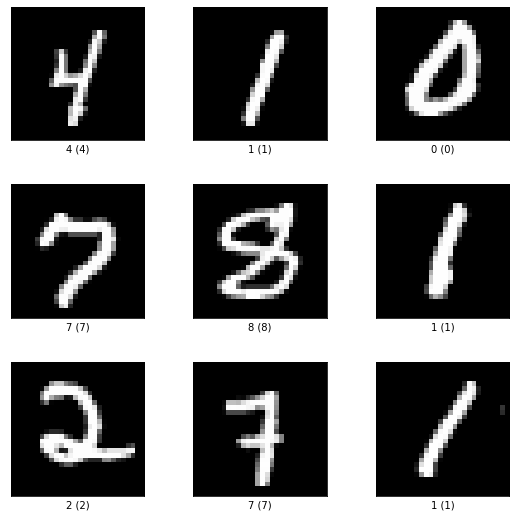

In [0]:
# Load the mnist dataset using tdfs
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
    try_gcs=True
)

# Output metadata to verify dataset has been imported
print(ds_info)

# Show some dataset examples
ds_example, ds_example_info = tfds.load('mnist', split='train', with_info=True)
fig = tfds.show_examples(ds_example, ds_example_info)

## Next up we build the training pipeline.

We apply the following transormations to the dataset.


*   ds.map: TFDS provides the images as tf.uint8 encoding, while the model expects tf.float32, so normalize the images to float32.
*   ds.cache As the dataset fits into memory, cache it before shuffling for better performance. Note: Random transformations should be applied after caching.
*   ds.shuffle: For true randomness, set the shuffle buffer to the full size of the dataset.
Note: For bigger datasets which do not fit in memory, a standard value is 1000 if your system allows it.
*   ds.batch: Batch after shuffling to get unique batches at each epoch.
*   ds.prefetch: It is good practice to end the pipeline by prefetching for performance.



In [0]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

## Build evaluation pipeline
The Testing pipeline is similar to the training pipeline, with small tweaks:


*   There is no ds.shuffle() call
*   Caching is done after batching (as batches can be the same between epoch)


In [0]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

# Define the plotting curves
This will be used to graph model accuracy and loss over time

In [0]:
"""
def plot_curve(epochs, hist, list_of_metrics):
  # Plot a curve of one or more classification metrics vs. epoch.
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure.Figure()
  plt.pyplot.xlabel("Epoch")
  plt.pyplot.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.pyplot.plot(epochs[1:], x[1:], label=m)

  plt.pyplot.legend()

print("Loaded the plot_curve function.")
"""

def plot_acc(hist):
  # plot the accuracy
  plt.title('Accuracy History')
  plt.plot(hist.history['accuracy'])
  plt.ylabel('Accuracy')
  plt.xlabel('epoch')
  plt.show()
  
def plot_loss(hist):
  # plot the loss
  plt.title('Loss History')
  plt.plot(hist.history['loss'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.show()

## Build and train the model

Input the training pipeline built above into Keras and define model parameters

In [0]:
def create_model(learning_rate):

  # Use an input shape of 28x28 because the images in MNIST are 28x28 pixels
  # reLU has been effective in most use cases including this one, add a relatively dense layer with 128 neurons
  # Use softmax activation function because we want a probability distribution

  model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
  ])

  # Compile model with SCC loss function, Adam optimizer and Accuracy metric
  # SCC is used when you have two or more label classes
  # Adam optimizer uses Stochastic Gradient Descent and is efficient when dealing with large datasets
  # Accuracy metric is used to calculate how often predictions from the model are equal to the real labels

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'],
  )

  return model

def train_model(model, epochs, batch_size):

  # Fit the model using the training split, then validate using the test split
  history = model.fit(
      ds_train,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=ds_test
  )

  # To track the progress of training, take a snapshot of the model metrics at each epoch and add it to a dataframe.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist, history



# Invoke previously defined functions

In [0]:
# These variables are the hyperparameters for the model.
learning_rate = 0.0005
epochs = 10
batch_size = 6000

# Define model topography
my_model = create_model(learning_rate)

# Train the model
epochs, hist, history = train_model(my_model,epochs,batch_size)

Epoch 1/10
469/469 [==============================] - 4s 8ms/step - loss: 0.4660 - accuracy: 0.8773 - val_loss: 0.2544 - val_accuracy: 0.9283
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.2210 - accuracy: 0.9380 - val_loss: 0.1914 - val_accuracy: 0.9457
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1716 - accuracy: 0.9517 - val_loss: 0.1578 - val_accuracy: 0.9562
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1408 - accuracy: 0.9601 - val_loss: 0.1351 - val_accuracy: 0.9610
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1192 - accuracy: 0.9662 - val_loss: 0.1204 - val_accuracy: 0.9645
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1014 - accuracy: 0.9713 - val_loss: 0.1103 - val_accuracy: 0.9681
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0886 - accuracy: 0.9755 - val_loss: 0.1049 - val_accuracy: 0.9692
Epoch 

# Plot output of accuracy and loss metrics

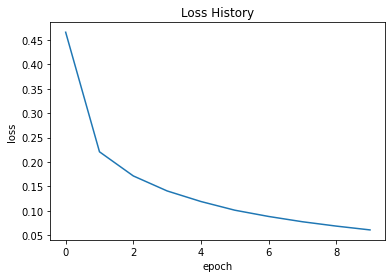

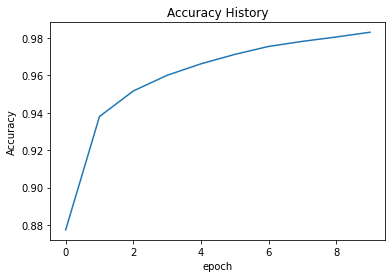

In [0]:
# Plot the collected metrics over time
"""
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)
"""
plot_loss(history)
plot_acc(history)


# Model Testing

In [0]:
print(ds_test)
predictions = my_model.predict(ds_test[:10])


count = 0
for x in range(len(predictions)):
    guess = (np.argmax(predictions[x]))
    actual = y_test[x]
    print("I predict this number is a:", guess)
    print("Number Actually Is a:", actual)
    if guess != actual:
        #print("--------------")
        #print('WRONG')
        #print('---------------')
        count+=1
    plt.imshow(x_test[x], cmap=plt.cm.binary)
    plt.show()

print("The program got", count, 'wrong, out of', len(x_test))
print(str(100 - ((count/len(x_test))*100)) + '% correct')

NameError: ignored